In [1]:
!apt-get install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [2]:
!unzip data.zip

Archive:  data.zip
  inflating: lenta_sample.csv        
  inflating: __MACOSX/._lenta_sample.csv  


In [42]:
!pip install transformers sklearn pandas matplotlib

     |████████████████████████████████| 11.5 MB 13.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 15.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [43]:
# стандартные библиотеки
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


# tf и huggingface 
import tensorflow as tf
from transformers import TFAutoModel
from transformers import AutoTokenizer


Возьмем данные lenta.ru, но не целиком. Fine-tuning больших моделей лучше всего подходит, когда данных совсем мало и стандартным алгоритмам просто не хватает информации, чтобы обучиться. Поэтому возьмем только небольшой процент всех данных.

In [2]:
data = pd.read_csv('lenta_sample.csv')
data.dropna(subset=['topic', 'text'], inplace=True)

In [3]:
data_frac = pd.concat([data[data.topic=='Россия'].sample(frac=0.001),
                      data[data.topic=='Мир'].sample(frac=0.001),
                      data[data.topic=='Экономика'].sample(frac=0.002),
                      data[data.topic=='Спорт'].sample(frac=0.003),
                      data[data.topic=='Наука и техника'].sample(frac=0.005),
                      data[data.topic=='Бывший СССР'].sample(frac=0.005),
                      data[data.topic=='Культура'].sample(frac=0.005),
                      data[data.topic=='Интернет и СМИ'].sample(frac=0.005),
                      data[data.topic=='Из жизни'].sample(frac=0.01),
                      data[data.topic=='Дом'].sample(frac=0.01),
                      data[data.topic=='Силовые структуры'].sample(frac=0.01),
                      data[data.topic=='Ценности'].sample(frac=0.03),
                      data[data.topic=='Бизнес'].sample(frac=0.03),
                      data[data.topic=='69-я параллель'].sample(frac=0.05),
                      data[data.topic=='Крым'].sample(frac=0.05),
                      data[data.topic=='Культпросвет'].sample(frac=0.2),
                      data[data.topic=='Легпром'].sample(frac=0.8),
                      data[data.topic=='Библиотека']]).reset_index(drop=True)

In [4]:
data_frac.topic.value_counts()

Из жизни             55
Бывший СССР          54
Наука и техника      54
Культура             53
Ценности             45
Дом                  45
Бизнес               44
Интернет и СМИ       44
Силовые структуры    40
Спорт                39
Экономика            32
Россия               32
Мир                  27
69-я параллель       13
Легпром              13
Библиотека           10
Крым                  7
Name: topic, dtype: int64

In [5]:
data_frac.shape

(607, 6)

In [6]:
data = data_frac

### Загружаем предобученную модель из huggingface transformers

Список всех доступных моделей можно найти тут - https://huggingface.co/models  
А вот тут основные с описанием - https://huggingface.co/transformers/pretrained_models.html

На HG предпочитают торч, поэтому многие модели не загрузятся в тф. Там есть специальный тэг, по которому можно фильтровать модели. Самые стандартные (англоязычный и мультиязычный) берты от гугла работают с тф. А вот стандартный ru-bert от DeepPavlov только на торче (смотрите в тетрадке по торчу к этому семинару)

In [7]:
# # Можно сказать оригинальный берт
# tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
# model_bert = AutoModel.from_pretrained('bert-base-cased')

In [10]:
# # Мультиязычный берт
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
model_bert = TFAutoModel.from_pretrained('bert-base-multilingual-cased')

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [43]:
# # # Rubert который есть на тф от неизвестного пользователя геотренд
# tokenizer = AutoTokenizer.from_pretrained("Geotrend/bert-base-ru-cased")
# model_bert = TFAutoModel.from_pretrained("Geotrend/bert-base-ru-cased")

Some layers from the model checkpoint at Geotrend/bert-base-ru-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at Geotrend/bert-base-ru-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Мы загружаем не только модель, а еще и токенайзер, т.е. свою предобработку нам писать не нужно

In [11]:
data.loc[4, 'title']

'Рыбкин поможет Хакамаде стать президентом России'

Перевести токены в индексы очень просто

In [12]:
tokenizer.encode(data.loc[4, 'title'])

[101,
 525,
 10292,
 67725,
 10267,
 96358,
 104998,
 530,
 34411,
 73287,
 10205,
 50121,
 48841,
 12152,
 102]

В этих моделях как правило используется BPE

In [13]:
# переводим индекс токена обратно в текст
encoded = tokenizer.encode(data.loc[4, 'title'])
[tokenizer.decode([x]) for x in encoded]

['[CLS]',
 'Р',
 '##ы',
 '##бки',
 '##н',
 'пом',
 '##ожет',
 'Х',
 '##ака',
 '##мад',
 '##е',
 'стать',
 'президентом',
 'России',
 '[SEP]']

Индексы можно напрямую передавать в модель.

In [14]:
text = data.loc[4, 'title']
text_ids = tf.constant([tokenizer.encode(text, add_special_tokens=True)])
output = model_bert(text_ids, output_attentions=False)

На выходе мы получим tuple из двух элементов. 

Первый элемент - состояния енкодера для каждого из элементов последовательности

In [15]:
output[0].shape # в пайторче вместо .shape используется size()

TensorShape([1, 15, 768])

Второй - состояние енкодера на первом элементе, пропущенное через активацию (обычно этот элемент не используют)

In [16]:
output[1].shape

TensorShape([1, 768])

Обычно в задачах используют либо состояние первого элемента

In [17]:
output[0][:,0].shape

TensorShape([1, 768])

Либо усредненное состояние 

In [18]:
tf.math.reduce_mean(output[0], axis=1).shape

TensorShape([1, 768])

Полученные эмбеддинги уже можно использовать для какой-нибудь кластеризации или поиска похожих. А если есть разметка, то можно обучить на этих векторах стандартную модель из sklearn или даже дообучить всего Берта под конкретную задачу!

Давайте попробуем дообучить (fine-tune) модель на данных lenta ru

In [19]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Будем обучаться на заголовках, а не на самих текстах

In [20]:
# переводим тексты в последовательности индексов
# У берта есть ограничение на максимальную длину последовательности - 512
# Для заголовков это не очень актуально, но для других данных пригодится

X = []

for text in data.title:
    ids = tokenizer.encode(text)
    
    X.append(ids[:512])

In [21]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [22]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])


In [23]:
X.shape

(607, 512)

В этот раз добавим стратификацию, т.к. в данных у нас дисбаланс классов.

In [24]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

In [25]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [37]:

input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = model_bert({"input_ids":input_word_ids})

# добавим дропаут чтобы не переобучалось
drop = tf.keras.layers.Dropout(0.3)(output[0][:, 0])
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)

# лосс нужно поставить поменьше
model_clf.compile(tf.optimizers.Adam(lr=2e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           f1])




С батчсайзом тут приходится уже быть осторожным, т.к. берт занимает очень много места на видеокарте. 

In [38]:
model_clf.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=16,
         epochs=20)

Epoch 1/20
36/36 [==============================] - 47s 648ms/step - loss: 2.9986 - accuracy: 0.1233 - f1: 0.0064 - val_loss: 2.4953 - val_accuracy: 0.1935 - val_f1: 0.0000e+00
Epoch 2/20
36/36 [==============================] - 16s 442ms/step - loss: 1.9715 - accuracy: 0.4132 - f1: 0.1411 - val_loss: 1.8663 - val_accuracy: 0.4839 - val_f1: 0.1181
Epoch 3/20
36/36 [==============================] - 16s 447ms/step - loss: 1.3084 - accuracy: 0.6615 - f1: 0.4522 - val_loss: 1.5755 - val_accuracy: 0.5806 - val_f1: 0.4188
Epoch 4/20
36/36 [==============================] - 16s 451ms/step - loss: 0.9227 - accuracy: 0.7934 - f1: 0.6675 - val_loss: 1.4404 - val_accuracy: 0.6129 - val_f1: 0.5473
Epoch 5/20
36/36 [==============================] - 16s 446ms/step - loss: 0.6839 - accuracy: 0.8542 - f1: 0.7956 - val_loss: 1.3580 - val_accuracy: 0.6129 - val_f1: 0.5994
Epoch 6/20
36/36 [==============================] - 16s 451ms/step - loss: 0.5661 - accuracy: 0.8872 - f1: 0.8277 - val_loss: 1.330

dict_keys(['loss', 'accuracy', 'f1', 'val_loss', 'val_accuracy', 'val_f1'])


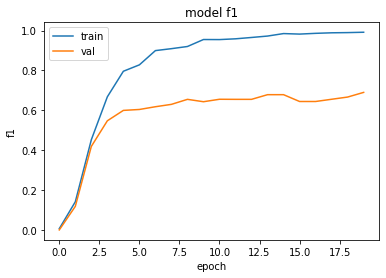

In [44]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['f1'])
plt.plot(model_clf.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [45]:
from sklearn.metrics import classification_report

In [48]:
pred = model_clf.predict(X_valid).argmax(1)

In [55]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

            Спорт       1.00      1.00      1.00         2
         Ценности       1.00      0.50      0.67         2
          Легпром       0.00      0.00      0.00         1
              Дом       0.67      1.00      0.80         2
   Интернет и СМИ       0.50      0.50      0.50         2
         Культура       1.00      1.00      1.00         3
        Экономика       0.00      0.00      0.00         2
             Крым       0.00      0.00      0.00         0
   69-я параллель       1.00      1.00      1.00         1
           Россия       1.00      1.00      1.00         2
      Бывший СССР       0.40      0.67      0.50         3
       Библиотека       0.00      0.00      0.00         0
  Наука и техника       0.75      1.00      0.86         3
         Из жизни       0.50      0.33      0.40         3
Силовые структуры       0.50      0.50      0.50         2
              Мир       0.00      0.00      0.00       

Ф-мера в 65 выглядит не очень, но нужно помнить, что мы обучились на 600 примерах. Для сравнения можно попробовать обучить лстм на тех же данных.

In [60]:

def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

vocab = Counter()

for text in data.title:
    vocab.update(preprocess(text))

# индексируем слова
word2id = {'PAD':0}

for word in vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

X = []

for text in data.title:
    tokens = preprocess(text)
    ids = [word2id[token] for token in tokens]
    X.append(ids)

MAX_LEN = max(len(x) for x in X)


# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=MAX_LEN)


id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=data.topic)

In [61]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', f1])


In [62]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 13, 30)            92580     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               81408     
_________________________________________________________________
dense_3 (Dense)              (None, 17)                2193      
Total params: 176,181
Trainable params: 176,181
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=50)

Epoch 1/50
18/18 [==============================] - 1s 42ms/step - loss: 0.5776 - accuracy: 0.8108 - f1: 0.8024 - val_loss: 5.0685 - val_accuracy: 0.1613 - val_f1: 0.1818
Epoch 2/50
18/18 [==============================] - 1s 44ms/step - loss: 0.4634 - accuracy: 0.8611 - f1: 0.8810 - val_loss: 5.4626 - val_accuracy: 0.1935 - val_f1: 0.2105
Epoch 3/50
18/18 [==============================] - 1s 49ms/step - loss: 0.3959 - accuracy: 0.8802 - f1: 0.8930 - val_loss: 5.5292 - val_accuracy: 0.1935 - val_f1: 0.2034
Epoch 4/50
18/18 [==============================] - 1s 36ms/step - loss: 0.4465 - accuracy: 0.8490 - f1: 0.8561 - val_loss: 5.5703 - val_accuracy: 0.1613 - val_f1: 0.1786
Epoch 5/50
18/18 [==============================] - 1s 28ms/step - loss: 0.4964 - accuracy: 0.8403 - f1: 0.8439 - val_loss: 5.1263 - val_accuracy: 0.2258 - val_f1: 0.2333
Epoch 6/50
18/18 [==============================] - 1s 31ms/step - loss: 0.4767 - accuracy: 0.8264 - f1: 0.8378 - val_loss: 5.3636 - val_accuracy

dict_keys(['loss', 'accuracy', 'f1', 'val_loss', 'val_accuracy', 'val_f1'])


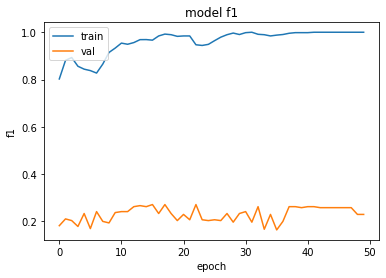

In [66]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()